In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import xgboost as xgb

from imblearn.over_sampling import SMOTE

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
travel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype
---  ------                 --------------   -----
 0   posa_continent         100000 non-null  int64
 1   user_location_country  100000 non-null  int64
 2   user_location_region   100000 non-null  int64
 3   user_location_city     100000 non-null  int64
 4   user_id                100000 non-null  int64
 5   srch_destination_id    100000 non-null  int64
 6   is_booking             100000 non-null  int64
 7   hotel_continent        100000 non-null  int64
 8   hotel_country          100000 non-null  int64
dtypes: int64(9)
memory usage: 6.9 MB


In [45]:
travel_df = pd.read_csv('travel.csv')

# Remove unnessecary columns
travel_df.drop(["hotel_cluster",
                "Unnamed: 0",
                "date_time",
                "site_name",
                "orig_destination_distance", 
                "is_mobile", 
                "is_package", 
                "channel", 
                "srch_ci", 
                "srch_co", 
                "srch_adults_cnt", 
                "srch_children_cnt", 
                "srch_rm_cnt", 
                "srch_destination_type_id", 
                "cnt", 
                "hotel_market",
                "hotel_cluster"], axis=1,inplace=True)
travel_df.head()

,posa_continent,user_location_country,user_location_region,user_location_city,user_id,srch_destination_id,is_booking,hotel_continent,hotel_country
0,2,77,871,36643,792280,8286,0,0,63
1,3,205,135,38749,961995,1842,0,2,198
2,3,66,314,48562,495669,8746,0,6,105
3,3,205,411,52752,106611,6210,1,2,198
4,3,66,174,50644,596177,12812,0,2,50


In [51]:
# Drop any nulls if present
travel_df_cleaned = travel_df.dropna()

# Keep only rows where users booked the hotel
travel_df_cleaned = travel_df_cleaned[travel_df_cleaned["is_booking"] == 1]

# Set the index to the user_id to remove it from the training data
travel_df_cleaned.set_index("user_id",inplace=True)

# Remove sparse classifications for continent < 5
classification_counts = travel_df_cleaned["hotel_continent"].value_counts()
travel_df_cleaned = travel_df_cleaned[travel_df_cleaned["hotel_continent"].isin(classification_counts[classification_counts >= 5].index)]

travel_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7992 entries, 106611 to 707315
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   posa_continent         7992 non-null   int64
 1   user_location_country  7992 non-null   int64
 2   user_location_region   7992 non-null   int64
 3   user_location_city     7992 non-null   int64
 4   srch_destination_id    7992 non-null   int64
 5   is_booking             7992 non-null   int64
 6   hotel_continent        7992 non-null   int64
 7   hotel_country          7992 non-null   int64
dtypes: int64(8)
memory usage: 561.9 KB


In [62]:
# Relabel to consistent classes
mapping = {2: 0, 6: 1, 3: 2, 4: 3, 0: 4, 5: 5}
travel_df_cleaned["hotel_continent"] = travel_df_cleaned["hotel_continent"].replace(mapping)

# Check classification group distribution
print(travel_df_cleaned["hotel_continent"].value_counts())

hotel_continent
4    4810
1    1546
0     853
2     562
3     150
5      71
Name: count, dtype: int64


In [63]:
# Prepare training and testing data

# For this first iteration we'll only focus on trying to predict the continent instead of the country or destination id
X = travel_df_cleaned.drop(["hotel_country", "srch_destination_id", "hotel_continent"], axis=1)

y = travel_df_cleaned["hotel_continent"]





X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

X.head()

,posa_continent,user_location_country,user_location_region,user_location_city,is_booking
user_id,,,,,
106611,3,205,411,52752,1
908558,3,66,337,54287,1
982283,3,66,189,19294,1
631966,3,66,174,48505,1
1161448,3,66,442,35390,1


In [64]:
# Check distribution to ensure all classes appear in test and training data
print("Training set class distribution:")
print(pd.Series(y_train).value_counts())

print("Test set class distribution:")
print(pd.Series(y_test).value_counts())

Training set class distribution:
hotel_continent
4    3861
1    1242
0     678
2     443
3     117
5      52
Name: count, dtype: int64
Test set class distribution:
hotel_continent
4    949
1    304
0    175
2    119
3     33
5     19
Name: count, dtype: int64


In [98]:
# Supervised ML Models
def random_forests(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(n_estimators=100, random_state=2)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True,zero_division=0)

    print("\nRandom Forest:")
    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return accuracy, report, y_pred

rf_accuracy, rf_report, y_pred = random_forests(X_train, X_test, y_train, y_test)


Random Forest:
Accuracy: 0.6641651031894934
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.45      0.46       175
           1       0.55      0.47      0.51       304
           2       0.28      0.11      0.16       119
           3       0.25      0.06      0.10        33
           4       0.74      0.87      0.80       949
           5       0.25      0.05      0.09        19

    accuracy                           0.66      1599
   macro avg       0.42      0.34      0.35      1599
weighted avg       0.62      0.66      0.64      1599



In [99]:
# Xgboost classifier
def xgboost(X_train, X_test, y_train, y_test):

    xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', max_depth=5, learning_rate=0.1, 
                                       n_estimators=150, random_state=3)

    xgb_classifier.fit(X_train, y_train)

    y_pred = xgb_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    print("\nXGBoost:")
    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return accuracy, report, y_pred

xgb_accuracy, xrb_report, y_pred = xgboost(X_train, X_test, y_train, y_test)


XGBoost:
Accuracy: 0.6954346466541589
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.46      0.49       175
           1       0.59      0.51      0.55       304
           2       0.41      0.09      0.15       119
           3       0.36      0.12      0.18        33
           4       0.75      0.91      0.82       949
           5       0.50      0.05      0.10        19

    accuracy                           0.70      1599
   macro avg       0.52      0.36      0.38      1599
weighted avg       0.66      0.70      0.66      1599



In [100]:
# Support Vector Machines
def SVM(X_train, X_test, y_train, y_test):

    # Scale X_test and X_train for SVM
    scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
    X_train_svm = scaling.transform(X_train)
    X_test_svm = scaling.transform(X_test)

    svm = SVC(kernel='rbf')  # use 'rbf' for a non-linear kernel
    svm.fit(X_train_svm, y_train)

    y_pred = svm.predict(X_test_svm)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    print("\nSVM:")
    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return accuracy, report, y_pred

svm_accuracy, svm_report, y_pred = SVM(X_train, X_test, y_train, y_test)


SVM:
Accuracy: 0.6804252657911195
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.40      0.46       175
           1       0.60      0.44      0.51       304
           2       0.33      0.02      0.03       119
           3       0.38      0.09      0.15        33
           4       0.71      0.93      0.81       949
           5       0.00      0.00      0.00        19

    accuracy                           0.68      1599
   macro avg       0.43      0.31      0.33      1599
weighted avg       0.63      0.68      0.63      1599



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [101]:
# NOTE: Warnings are due to unbalanced data, which will be addressed later on

In [102]:
# Solution 1: SMOTE

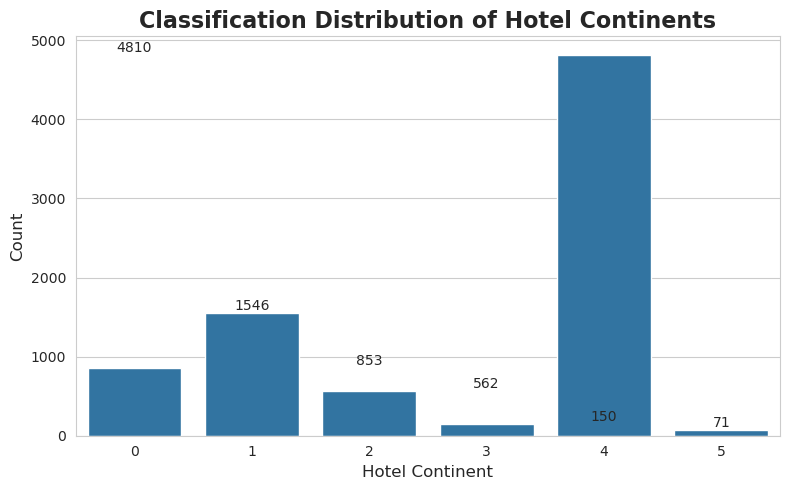

In [103]:
class_counts = travel_df_cleaned['hotel_continent'].value_counts()

sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(
    x=class_counts.index,
    y=class_counts.values,
)

plt.title('Classification Distribution of Hotel Continents', fontsize=16, fontweight='bold')
plt.xlabel('Hotel Continent', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Annotations
for i, count in enumerate(class_counts.values):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)


plt.tight_layout()
plt.show()

In [106]:
smote = SMOTE(random_state=2)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Random Forests with SMOTE
rf_smote_accuracy, rf_smote_report, y_pred = random_forests(X_train_smote, X_test, y_train_smote, y_test)

# XGBoost with SMOTE
xgb_smote_accuracy, xrb_smote_report, y_pred = xgboost(X_train, X_test, y_train, y_test)

# Support Vector Machines with SMOTE
svm_smote_accuracy, svm_smote_report, y_pred = SVM(X_train_smote, X_test, y_train_smote, y_test)


Random Forest:
Accuracy: 0.5953721075672295
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.44      0.41       175
           1       0.50      0.42      0.46       304
           2       0.21      0.30      0.25       119
           3       0.29      0.30      0.29        33
           4       0.76      0.73      0.75       949
           5       0.17      0.21      0.19        19

    accuracy                           0.60      1599
   macro avg       0.39      0.40      0.39      1599
weighted avg       0.61      0.60      0.60      1599


XGBoost:
Accuracy: 0.6954346466541589
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.46      0.49       175
           1       0.59      0.51      0.55       304
           2       0.41      0.09      0.15       119
           3       0.36      0.12      0.18        33
           4       0.75      0.91      0.82       949
  


Random Forest:

Random Forest:
Accuracy: 0.5953721075672295
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.44      0.41       175
           1       0.50      0.42      0.46       304
           2       0.21      0.30      0.25       119
           3       0.29      0.30      0.29        33
           4       0.76      0.73      0.75       949
           5       0.17      0.21      0.19        19

    accuracy                           0.60      1599
   macro avg       0.39      0.40      0.39      1599
weighted avg       0.61      0.60      0.60      1599



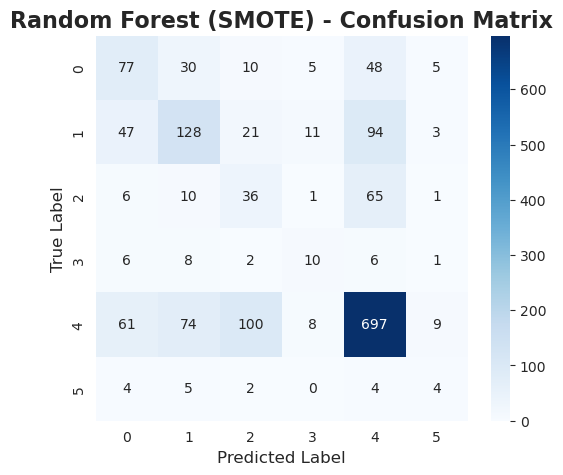


XGBoost:

XGBoost:
Accuracy: 0.6954346466541589
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.46      0.49       175
           1       0.59      0.51      0.55       304
           2       0.41      0.09      0.15       119
           3       0.36      0.12      0.18        33
           4       0.75      0.91      0.82       949
           5       0.50      0.05      0.10        19

    accuracy                           0.70      1599
   macro avg       0.52      0.36      0.38      1599
weighted avg       0.66      0.70      0.66      1599



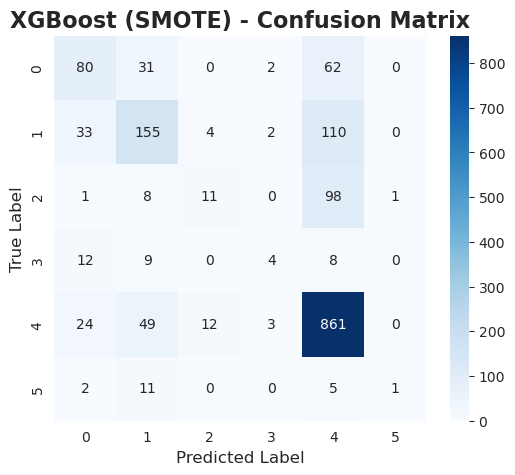


SVM:

SVM:
Accuracy: 0.6660412757973734
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.38      0.46       175
           1       0.63      0.35      0.45       304
           2       0.36      0.19      0.25       119
           3       0.31      0.45      0.37        33
           4       0.74      0.90      0.81       949
           5       0.08      0.26      0.12        19

    accuracy                           0.67      1599
   macro avg       0.45      0.42      0.41      1599
weighted avg       0.66      0.67      0.64      1599



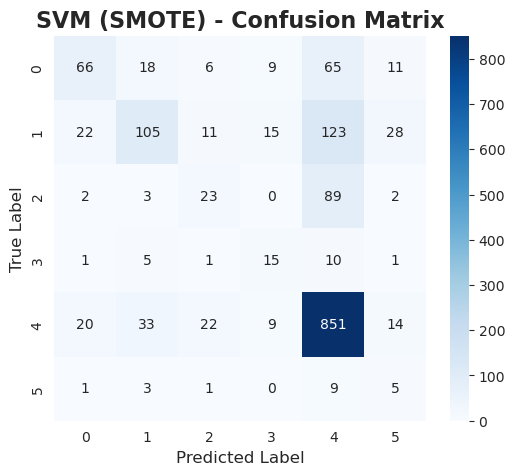

In [107]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_true), yticklabels=set(y_true))
    plt.title(f"{model_name} - Confusion Matrix", fontsize=16, fontweight='bold')
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.show()

# Random Forests with SMOTE
print("\nRandom Forest:")
rf_smote_accuracy, rf_smote_report, rf_y_pred = random_forests(X_train_smote, X_test, y_train_smote, y_test)
plot_confusion_matrix(y_test, rf_y_pred, "Random Forest (SMOTE)")

# XGBoost with SMOTE
print("\nXGBoost:")
xgb_smote_accuracy, xgb_smote_report, xgb_y_pred = xgboost(X_train, X_test, y_train, y_test)
plot_confusion_matrix(y_test, xgb_y_pred, "XGBoost (SMOTE)")

# Support Vector Machines with SMOTE
print("\nSVM:")
svm_smote_accuracy, svm_smote_report, svm_y_pred = SVM(X_train_smote, X_test, y_train_smote, y_test)
plot_confusion_matrix(y_test, svm_y_pred, "SVM (SMOTE)")